In [1]:
from __future__ import print_function
import numpy as np
import numpy.random as npr
import torch as th
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.modules.loss import CrossEntropyLoss, MSELoss
import torch.nn.functional as F
from torch.optim import SGD, Adam
import my

In [2]:
N_TRAIN, N_TEST = 0, 0
train_data, train_labels, test_data, test_labels = my.unbalanced_dataset(
    'MNIST', N_TRAIN, N_TEST, pca=False, p=[])

train_data_np, train_labels_np, test_data_np, test_labels_np = \
    train_data, train_labels, test_data, test_labels
    
train_data = th.from_numpy(train_data).float()
train_labels = th.from_numpy(train_labels).long()
test_data = th.from_numpy(test_data).float()
test_labels = th.from_numpy(test_labels).long()

cuda = True
if cuda:
    th.cuda.set_device(2)
    train_data, train_labels = train_data.cuda(), train_labels.cuda()
    test_data, test_labels = test_data.cuda(), test_labels.cuda()

train_data, train_labels, test_data, test_labels = \
    map(Variable, (train_data, train_labels, test_data, test_labels))

N_FEATURES = train_data.size()[1]
N_CLASSES = int(train_labels.max() - train_labels.min() + 1)

In [3]:
# class CNN(nn.Module):
#     def __init__(self, n_classes):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
#         self.conv2 = nn.Conv2d(16, 8, 3, 2, 1)
#         self.linear = nn.Linear(8, n_classes)
    
#     def forward(self, x):
#         if x.dim() != 4:
#             x = x.view(-1, 1, 28, 28)
#         x = F.tanh(self.conv1(x))
#         x = F.tanh(self.conv2(x))
#         x = F.avg_pool2d(x, 7)
#         x = self.linear(x.view(-1, 8))
#         return x

In [4]:
c = nn.Linear(N_FEATURES, N_CLASSES)
if cuda:
    c.cuda()
optim = Adam(c.parameters(), lr=0.001)
N_ITERATIONS = 10000
for i in range(N_ITERATIONS):
    loss = CrossEntropyLoss()(c(train_data), train_labels)
    if (i + 1) % 1000 == 0:
        accuracy = my.accuracy(my.predict(c, test_data), test_labels)
        print('[iteration %d]cross-entropy loss: %f, accuracy: %f' % ((i + 1), float(loss), float(accuracy)))
    optim.zero_grad()
    loss.backward()
    optim.step()

[iteration 1000]cross-entropy loss: 0.236590, accuracy: 0.923900
[iteration 2000]cross-entropy loss: 0.219120, accuracy: 0.924500
[iteration 3000]cross-entropy loss: 0.211648, accuracy: 0.925500
[iteration 4000]cross-entropy loss: 0.207435, accuracy: 0.924400
[iteration 5000]cross-entropy loss: 0.204792, accuracy: 0.922500
[iteration 6000]cross-entropy loss: 0.203101, accuracy: 0.921300
[iteration 7000]cross-entropy loss: 0.202018, accuracy: 0.920800
[iteration 8000]cross-entropy loss: 0.201327, accuracy: 0.920300
[iteration 9000]cross-entropy loss: 0.200891, accuracy: 0.919300
[iteration 10000]cross-entropy loss: 0.200616, accuracy: 0.918800


In [5]:
y_bar = my.predict(c, test_data)
accuracy = my.accuracy(y_bar, test_labels)
precision = my.nd_precision(y_bar, test_labels, N_CLASSES)
recall = my.nd_recall(y_bar, test_labels, N_CLASSES)
f1 = my.nd_f_beta(y_bar, test_labels, N_CLASSES)
print('accuracy: %f, precision: %f, recall: %f, f1: %f' % tuple(map(float, (accuracy, precision, recall, f1))))

accuracy: 0.919000, precision: 0.918198, recall: 0.917939, f1: 0.918063


# Algorithm

Let $c$ be a classifier and $D=\{(X_1, y_1),...,(X_N, y_N)\}$ be the set of training data. In order to minimize $L(c, D)$, where $L$ is a non-decomposable loss function, we introduce $L_\theta$, a parameterized approximation of $L(c, D)$, and update $c$ as follows:

1. Compute $\delta = L(c, D)-L(\bar{c},D)$, where $\bar{c}$ is obtained by stochastically perturbing the parameters of $c$

2. Randomly sample $K$ subsets, $D_1, ..., D_K$, of $D$ (these subsets may vary in cardinality)

3. Minimize $(\delta - \frac1K \sum_{i = 1}^K \delta_i)^2$ with respect to $\theta$, where $\delta_i = L_\theta(c, D_i) - L_\theta(\bar{c}, D_i)$

4. Repeat 1, 2, and 3 several times until $L_\theta$ becomes a satisfactory approximation of $L$ near $c$

5. Randomly sample $K'$ subsets, $D_1, ..., D_K'$, of $D$ and let $c \leftarrow c - \alpha \sum_{i = 1}^K \frac{\partial L_\theta}{\partial c} (c, D_i)$, where $\alpha$ is a positive learning rate

In [6]:
SAMPLE_SIZE = 64
BATCH_SIZE = 16

def L(classifier, X, y):
    y_bar = my.predict(classifier, X)
    return my.nd_f_beta(y_bar, y, N_CLASSES)

def forward(classifier, pair):
    X, y = pair
    y = my.onehot(y, N_CLASSES)
    y_bar = F.softmax(classifier(X), 1)
    return th.cat((y, y_bar), 1).view(1, -1)
    
def sample():
    samples = [my.sample_subset(train_data_np, train_labels_np, SAMPLE_SIZE) for k in range(BATCH_SIZE)]
    if cuda:
        samples = [(X.cuda(), y.cuda()) for (X, y) in samples]
    return [(Variable(X), Variable(y)) for (X, y) in samples]

In [7]:
c = nn.Linear(N_FEATURES, N_CLASSES)
# c = CNN(N_CLASSES)
# critic = my.MLP(((N_CLASSES +  N_CLASSES) * SAMPLE_SIZE,) + (1024,) * 3 +(1,), F.relu)
critic = my.RN(SAMPLE_SIZE, 2 * N_CLASSES, (1024,) * 3 + (1,), F.relu)

if cuda:
    c.cuda()
    critic.cuda()

# c_optim = SGD(c.parameters(), 0.1, momentum=0.9)
# critic_optim = SGD(critic.parameters(), 0.1, momentum=0.9)
c_optim = Adam(c.parameters(), 1e-3)
critic_optim = Adam(critic.parameters(), 1e-3)

float(my.nd_f_beta(my.predict(c, test_data), test_labels, N_CLASSES))

0.07059161365032196

In [8]:
STD = 0.1
OUTER = 500
INNER = 10

stats = []
for i in range(OUTER):
    f1 = L(c, train_data, train_labels)
    f1_list = []
    for j in range(INNER):
        c_bar = my.perturb(c, STD)
        f1_bar = L(c_bar, train_data, train_labels)
        delta = f1 - f1_bar
        f1_list.append(float(f1))

        samples = sample()
        y = th.cat(tuple(map(lambda x: forward(c, x), samples)), 0)
        y_bar = th.cat(tuple(map(lambda x: forward(c_bar, x), samples)), 0)
        delta_ = th.mean(critic(y) - critic(y_bar), 0)
        
        mse = MSELoss()(delta_, delta)
        critic_optim.zero_grad()
        mse.backward()
        critic_optim.step()
    
    samples = sample()
    y = th.cat(tuple(map(lambda x: forward(c, x), samples)), 0)
    objective = -th.mean(critic(y))
    c_optim.zero_grad()
    objective.backward()
    c_optim.step()
    stats.append(f1_list)
    
    if (i + 1) % 100 == 0:
        y_bar = my.predict(c, test_data)
        f1 = my.nd_f_beta(y_bar, test_labels, N_CLASSES)
        print('[iteration %d]mse: %f, objective: %f, f1: %f' % ((i + 1), float(mse), float(objective), float(f1)))

[iteration 100]mse: 0.000068, objective: -0.636298, f1: 0.442432
[iteration 200]mse: 0.000042, objective: -1.235656, f1: 0.579348
[iteration 300]mse: 0.000428, objective: -0.943639, f1: 0.614782
[iteration 400]mse: 0.000073, objective: -2.605721, f1: 0.722116
[iteration 500]mse: 0.000195, objective: -2.650117, f1: 0.768772


In [9]:
y_bar = my.predict(c, test_data)
accuracy = my.accuracy(y_bar, test_labels)
precision = my.nd_precision(y_bar, test_labels, N_CLASSES)
recall = my.nd_recall(y_bar, test_labels, N_CLASSES)
f1 = my.nd_f_beta(y_bar, test_labels, N_CLASSES)
print('accuracy: %f, precision: %f, recall: %f, f1: %f' % tuple(map(float, (accuracy, precision, recall, f1))))

accuracy: 0.786200, precision: 0.755890, recall: 0.782111, f1: 0.768772


In [10]:
import matplotlib.pylab as pl
%matplotlib inline

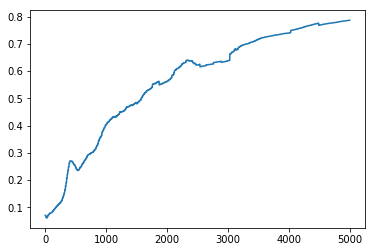

In [11]:
pl.plot(range(sum(map(len, stats))), sum(stats, []))

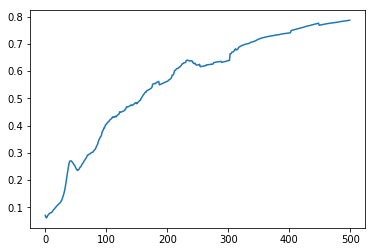

In [12]:
pl.plot(range(len(stats)), tuple(map(max, stats)))

In [13]:
th.save(critic.state_dict(), 'mnist_critic')